In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [36]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-add-remove-small-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
1737,90,add,156000,0.1,0.0,zipf,0,5,mpi_priority_frontier_simd,2.0,60.0,2,36553,0,18216,0,15600
710,104,add,156000,0.5,1.0,zipf,0,18,mpi_priority_frontier,32.0,60.0,32,35469,0,320138,0,78000
1988,99,add,156000,0.4,0.0,zipf,0,17,mpi_priority_frontier,3.0,60.0,3,36264,0,3623795,0,62400
744,247,addremove,240000,0.3,0.5,zipf,0,17,mpi_priority_frontier_simd,16.0,60.0,16,41982,0,1576618,0,107377
3362,219,remove,212000,0.4,0.0,zipf,0,2,mpi_priority_frontier_simd,64.0,60.0,64,33318,0,310765,0,84496


In [23]:
def agg_all_same(values):
    # assert (values == values.iloc[0]).all()
    return values.iloc[0]

def prepare_plot_data(filter_cb, index):
    temp = benchmark_results.copy()
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).agg({
        'input_strategy': agg_all_same,
        'input_length_1': agg_all_same,
        'input_change_strength': agg_all_same,
        'input_chunkiness': agg_all_same,
        'micros_until_len': 'median',
    })
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

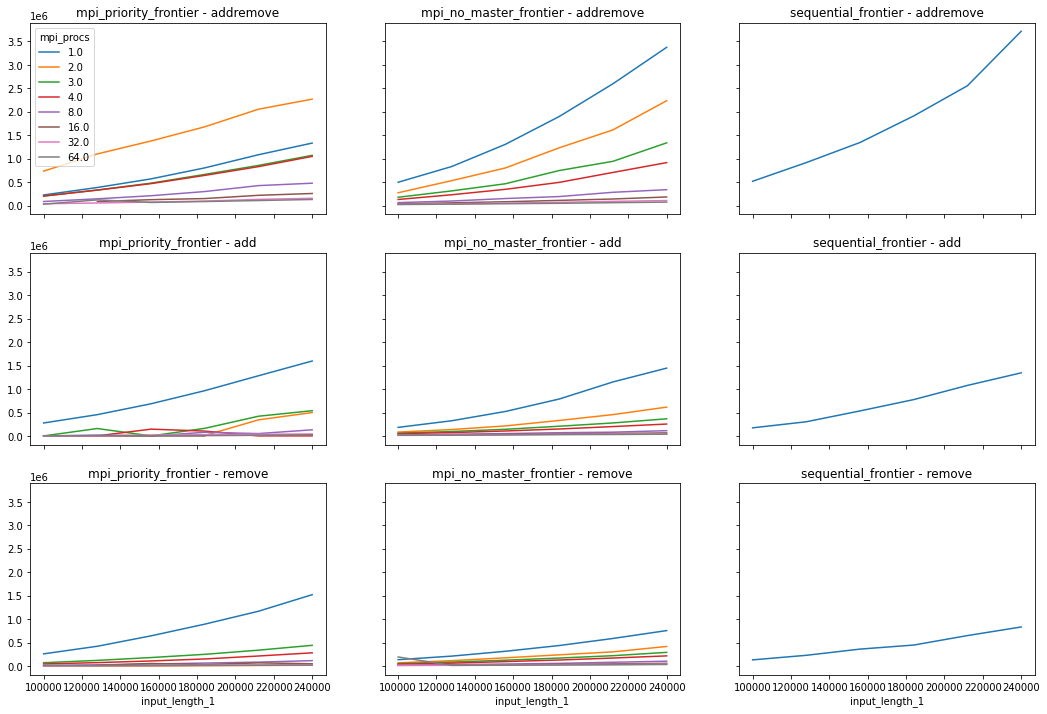

In [40]:
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = prepare_plot_data(
            lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)],
            'input_length_1',
        )
        temp = temp.droplevel('diff_program')
        temp.plot(ax=ax[input_strategy_i][diff_program_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}');

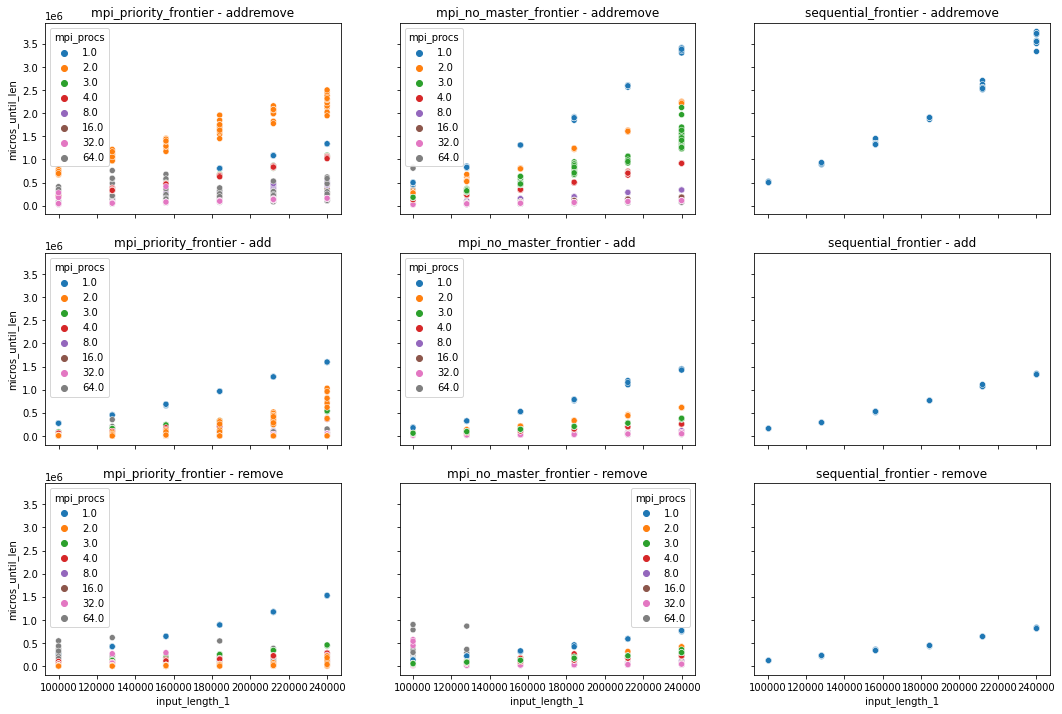

In [42]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = benchmark_results.copy()
        temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].min()) & (temp['input_chunkiness'] == 0)]
        this_ax = ax[input_strategy_i][diff_program_i]
        sns.scatterplot(data=temp, x='input_length_1', y='micros_until_len', hue='mpi_procs', palette=palette, ax=this_ax);
        this_ax.set_title(f'{diff_program} - {input_strategy}')

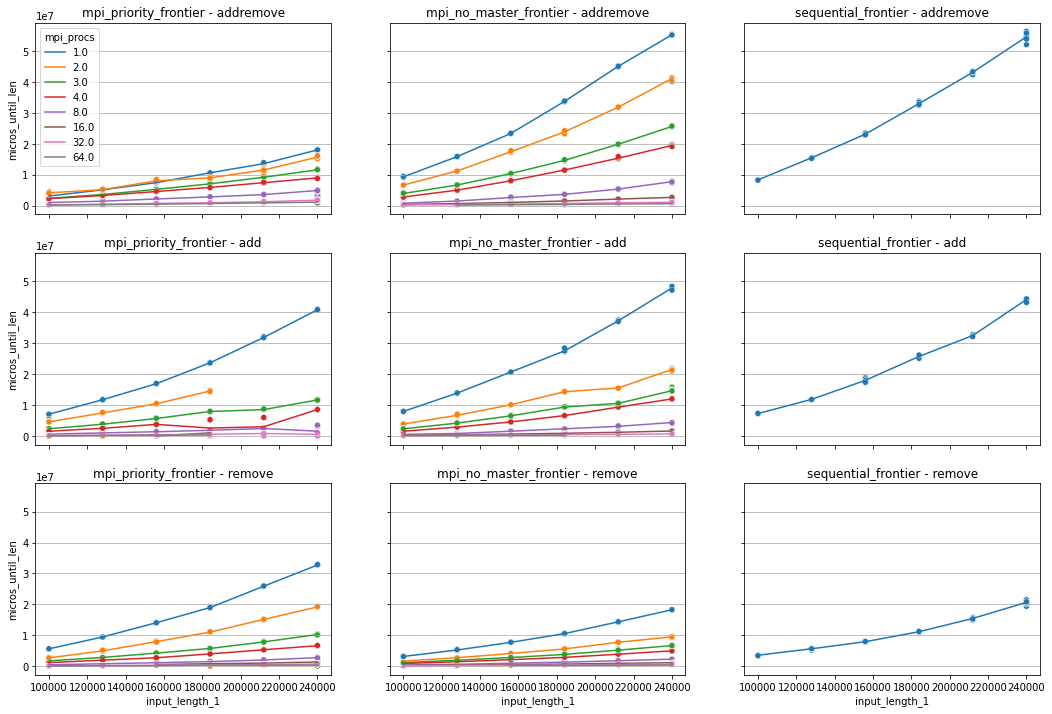

In [49]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna(1)
        temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].max()) & (temp['input_chunkiness'] == 0)]
        
        temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['micros_until_len'].median().unstack('mpi_procs')
        
        this_ax = ax[input_strategy_i][diff_program_i]
        sns.scatterplot(data=temp, x='input_length_1', y='micros_until_len', hue='mpi_procs', palette=palette, ax=this_ax, legend=((diff_program_i == 0) & (input_strategy_i == 0)));
        temp_2.plot(ax=this_ax, legend=False);
        this_ax.set_title(f'{diff_program} - {input_strategy}')
        this_ax.grid(axis='y')

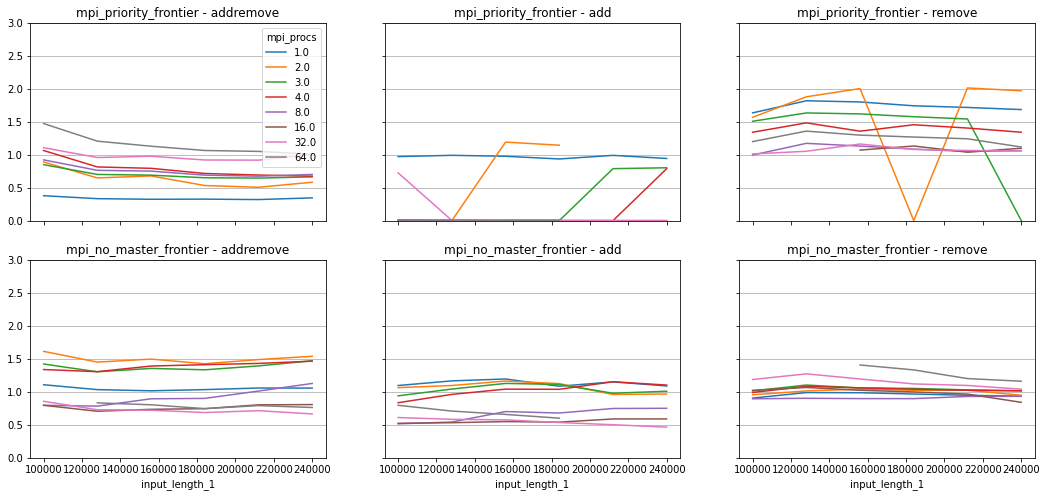

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    for input_strategy_i, input_strategy in enumerate(['addremove', 'add', 'remove']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
        temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
        temp = temp[(temp['input_strategy'] == input_strategy) & (temp['input_change_strength'] == temp['input_change_strength'].max()) & (temp['input_chunkiness'] == 0)]
        temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
        temp_3 = temp.xs('sequential_frontier', level='diff_program').set_index("input_length_1")["micros_until_len"]
        temp = temp_2.divide(temp_3, axis=0)
        temp *= temp.columns.values
        temp.plot(ax=ax[diff_program_i][input_strategy_i], legend=(input_strategy_i == 0 and diff_program_i == 0), title=f'{diff_program} - {input_strategy}', ylim=(0, 3));
        ax[diff_program_i][input_strategy_i].grid(axis='y')